<a href="https://colab.research.google.com/github/FarrahTharwat/Deep-Learning/blob/main/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
mydrive_path = '/content/drive/MyDrive/potato/Deep Project'
print(os.listdir(mydrive_path))

['Potato___Late_blight', 'Potato___healthy', 'Potato___Early_blight']


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from PIL import Image

In [ ]:
base_dir = "/content/drive/MyDrive/potato/Deep Project"
print(os.listdir(base_dir))

['Potato___Late_blight', 'Potato___healthy', 'Potato___Early_blight']


Class directory: /content/drive/MyDrive/potato/Deep Project/Potato___Late_blight
Image path: /content/drive/MyDrive/potato/Deep Project/Potato___Late_blight/bf6ce80d-ca31-4d72-b56a-dbd6e6f2847a___RS_LB 4022.JPG
Image details: JPEG (256, 256) RGB


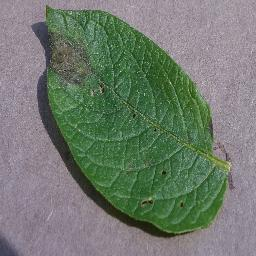

In [ ]:
# Path to the color folder
color_dir = os.path.join("/content/drive/MyDrive/potato/Deep Project")

# Navigate into the first subdirectory
class_dir = os.path.join(color_dir, os.listdir(color_dir)[0])
print("Class directory:", class_dir)

# Get the first image in the subdirectory
image_path = os.path.join(class_dir, os.listdir(class_dir)[0])
print("Image path:", image_path)

# Load the image
image = Image.open(image_path)

# If you want to check image details (like size, mode, etc.)
print("Image details:", image.format, image.size, image.mode)

# Display the image inline in the notebook
display(image)

Subdirectories in the dataset path: ['Potato___Late_blight', 'Potato___healthy', 'Potato___Early_blight']
Processing folder: Potato___Late_blight, Number of images: 1000
Processing folder: Potato___healthy, Number of images: 152
Processing folder: Potato___Early_blight, Number of images: 338
Unique labels: ['Potato___Late_blight' 'Potato___healthy' 'Potato___Early_blight']
Number of rows: 1490
Training set size: 1043
Validation set size: 223
Test set size: 224
Found 1043 validated image filenames belonging to 3 classes.
Found 223 validated image filenames belonging to 3 classes.
Found 224 validated image filenames belonging to 3 classes.


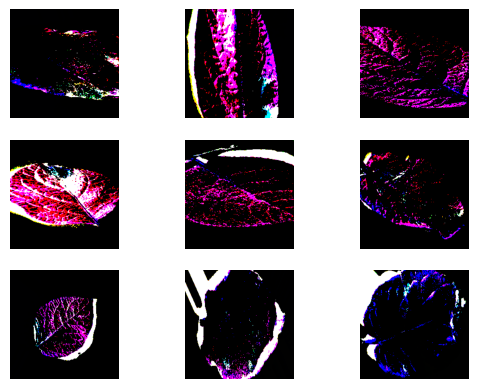

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Step 1: Create the DataFrame for "Potato" files only
def create_dataframe(df_path):
    if not os.path.exists(df_path):
        raise FileNotFoundError(f"The directory {df_path} does not exist. Check the path!")

    filepaths = []
    labels = []

    folds = os.listdir(df_path)  # List all subdirectories
    print(f"Subdirectories in the dataset path: {folds}")  # Debugging

    for fold in folds:
        # Process only "Potato" categories
        if "Potato" in fold:
            f_path = os.path.join(df_path, fold)
            imgs = os.listdir(f_path)
            print(f"Processing folder: {fold}, Number of images: {len(imgs)}")  # Debugging

            for img in imgs:
                img_path = os.path.join(f_path, img)
                filepaths.append(img_path)
                labels.append(fold)

    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    return pd.concat([fseries, lseries], axis=1)

# Specify the dataset path
dataset_path = '/content/drive/MyDrive/potato/Deep Project'

# Step 2: Create DataFrame with only "Potato" files
df = create_dataframe(dataset_path)

# Debugging: Check DataFrame content
print(f"Unique labels: {df['Labels'].unique()}")
print(f"Number of rows: {len(df)}")

# Step 3: Split the DataFrame into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Labels'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Labels'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Step 4: Define ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    shear_range=0.5,  # Increase shear range
    zoom_range=0.5,  # Increase zoom range
    rotation_range=45,  # Increase rotation range
    horizontal_flip=True,
    vertical_flip=True,  # Add vertical flip
    preprocessing_function=preprocess_input
)


val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Step 5: Use flow_from_dataframe() for TensorFlow generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)




val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Step 6: Optional: Visualize some training images
sample_images, sample_labels = next(train_generator)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i].astype('uint8'))
    plt.axis('off')
plt.show()


In [ ]:
import os
from PIL import Image

def validate_images(df, image_column='Filepaths'):
    valid_filepaths = []
    invalid_filepaths = []

    for filepath in df[image_column]:
        try:
            # Try to open the image
            with Image.open(filepath) as img:
                img.verify()  # Verify that the image is valid
            valid_filepaths.append(filepath)
        except (IOError, SyntaxError) as e:
            print(f"Corrupt image found: {filepath}, Error: {e}")
            invalid_filepaths.append(filepath)

    # Filter out invalid images
    df_valid = df[df[image_column].isin(valid_filepaths)].reset_index(drop=True)
    return df_valid, invalid_filepaths

# Validate images in your DataFrame
df, corrupt_images = validate_images(df)
print(f"Number of valid images: {len(df)}")
print(f"Number of corrupt images: {len(corrupt_images)}")


Number of valid images: 1490
Number of corrupt images: 0


Labels
Potato___Late_blight     1000
Potato___Early_blight     338
Potato___healthy          152
Name: count, dtype: int64


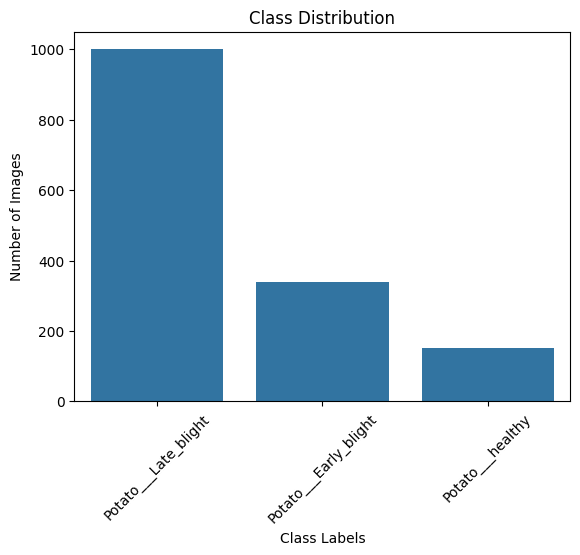

In [ ]:
class_counts = df['Labels'].value_counts()
print(class_counts)

# Visualize the class distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
import tensorflow as tf

# Load the DenseNet121 model with pre-trained weights (ImageNet)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Freeze the base model to retain the pre-trained weights during the initial phase of training
# base_model.trainable = False
# Unfreeze only the last few layers (e.g., unfreeze the last block of layers)
for layer in base_model.layers[:-20]:  # Unfreeze last 20 layers instead of 10
    layer.trainable = False




# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduces dimensions while retaining features
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout to reduce overfitting
    layers.Dense(len(train_generator.class_indices), activation='softmax')  # Output layer for multi-class classification


])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,090,179 (30.86 MB)

 Trainable params: 1,419,843 (5.42 MB)

 Non-trainable params: 6,670,336 (25.45 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop training if no improvement for 5 epochs
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Change the file extension to .keras
    monitor='val_loss',
    save_best_only=True
)



# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Adjust as needed
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 286s 8s/step - accuracy: 0.2969 - loss: 11.7645 - val_accuracy: 0.3274 - val_loss: 11.3768
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 291s 7s/step - accuracy: 0.3263 - loss: 11.6118 - val_accuracy: 0.5471 - val_loss: 11.2506
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 241s 7s/step - accuracy: 0.4052 - loss: 11.4283 - val_accuracy: 0.6233 - val_loss: 11.1692
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 236s 7s/step - accuracy: 0.4729 - loss: 11.3367 - val_accuracy: 0.6592 - val_loss: 11.1095
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 264s 7s/step - accuracy: 0.4936 - loss: 11.2741 - val_accuracy: 0.6996 - val_loss: 11.0611
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 262s 7s/step - accuracy: 0.5232 - loss: 11.1882 - val_accuracy: 0.6861 - val_loss: 11.0204
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 264s 7s/step - accuracy: 0.5476 - loss: 11.1935 - val_accuracy: 0.6726 - val_loss: 10.9853
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 261s 7s/step - accuracy: 0.5612 - loss: 11.1247 - val_accur

In [ ]:
#fine tune the model
from tensorflow.keras import initializers

# Unfreeze more layers (for example, unfreeze last 50 layers instead of 20)
# for layer in base_model.layers[:-10]:
#     layer.trainable = False
# # Freeze the base model to retain the pre-trained weights during the initial phase of training
base_model.trainable = False

# Adjusting the model architecture to experiment with weight initializers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu', kernel_initializer=initializers.he_normal(), kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile the model with a learning rate adjustment (try a higher value like 1e-5)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Adjusted learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with callbacks
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # Consider running for more epochs
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 258s 7s/step - accuracy: 0.5592 - loss: 21.5197 - val_accuracy: 0.6996 - val_loss: 21.0975
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 231s 7s/step - accuracy: 0.6569 - loss: 21.2750 - val_accuracy: 0.7309 - val_loss: 20.8628
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 258s 7s/step - accuracy: 0.6937 - loss: 20.9472 - val_accuracy: 0.7444 - val_loss: 20.6601
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 262s 7s/step - accuracy: 0.7041 - loss: 20.7722 - val_accuracy: 0.7803 - val_loss: 20.4436
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 230s 7s/step - accuracy: 0.6658 - loss: 20.6015 - val_accuracy: 0.7892 - val_loss: 20.2485


In [ ]:
# Save the fine-tuned model in the newer .keras format
model.save('fine_tuned_model.keras')



In [ ]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.7283 - loss: 21.0210
Validation Loss: 21.0975399017334
Validation Accuracy: 0.6995515823364258


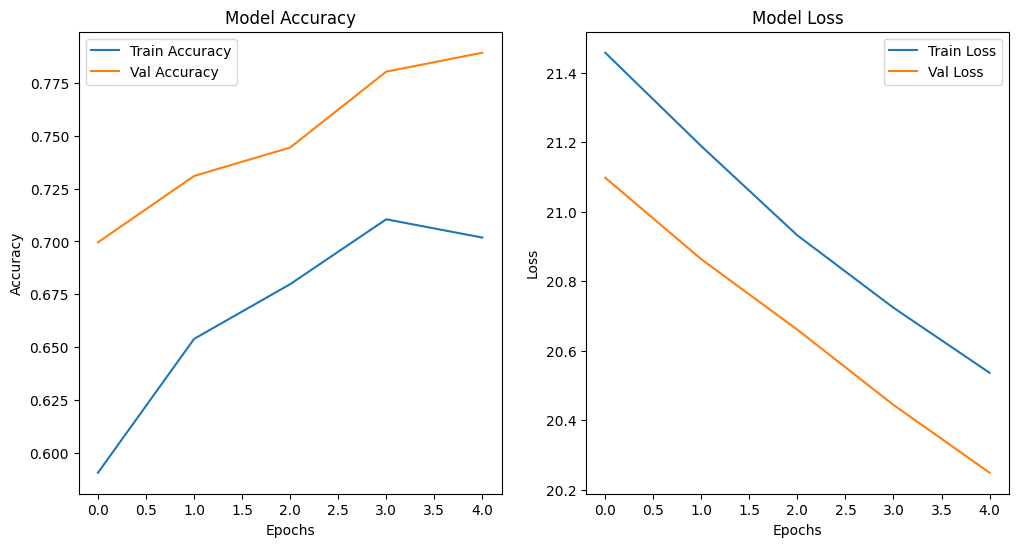

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 60s 7s/step


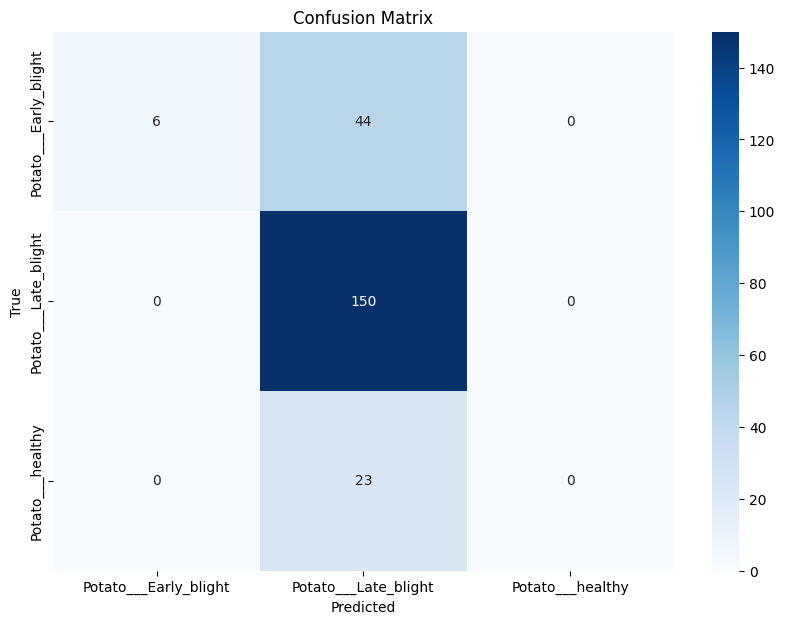

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the classes of the validation set
val_pred = model.predict(val_generator)
val_pred_classes = np.argmax(val_pred, axis=1)

# Get true labels
val_true_classes = val_generator.classes

# Generate the confusion matrix
cm = confusion_matrix(val_true_classes, val_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(val_true_classes, val_pred_classes, target_names=val_generator.class_indices.keys())
print(report)


                       precision    recall  f1-score   support

Potato___Early_blight       1.00      0.12      0.21        50
 Potato___Late_blight       0.69      1.00      0.82       150
     Potato___healthy       0.00      0.00      0.00        23

             accuracy                           0.70       223
            macro avg       0.56      0.37      0.34       223
         weighted avg       0.69      0.70      0.60       223



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step


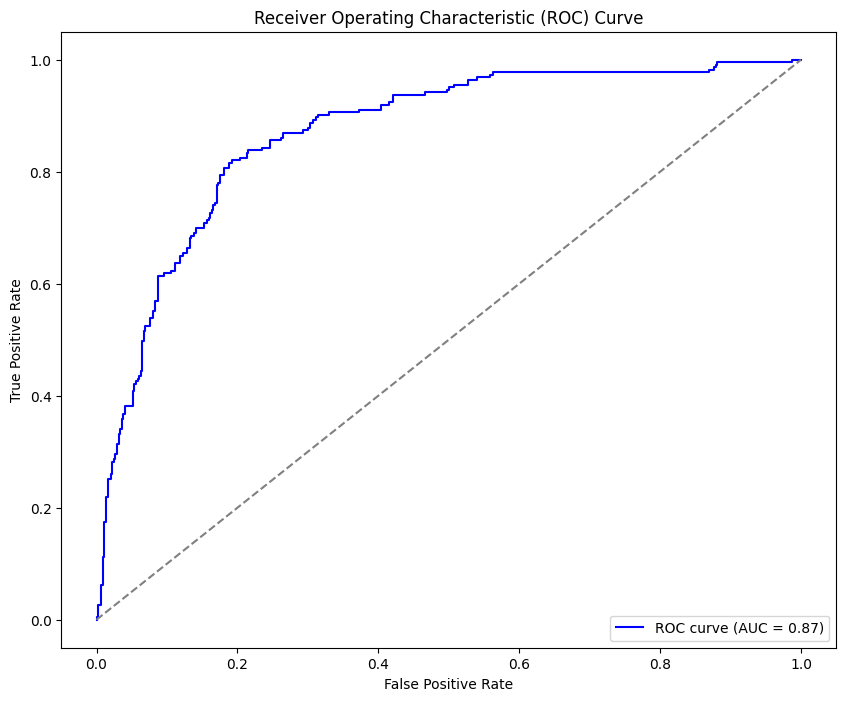

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC calculation
y_true = label_binarize(val_true_classes, classes=np.arange(len(val_generator.class_indices)))
y_pred = model.predict(val_generator)

# Calculate ROC and AUC for each class
fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, checkpoint]

)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 283s 8s/step - accuracy: 0.7188 - loss: 19.5826 - val_accuracy: 0.8789 - val_loss: 19.2680
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 241s 7s/step - accuracy: 0.7375 - loss: 19.3913 - val_accuracy: 0.8879 - val_loss: 19.1139
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 260s 7s/step - accuracy: 0.7618 - loss: 19.2248 - val_accuracy: 0.9103 - val_loss: 18.9478
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 258s 7s/step - accuracy: 0.7869 - loss: 19.0913 - val_accuracy: 0.9103 - val_loss: 18.7970
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 260s 7s/step - accuracy: 0.7729 - loss: 18.9660 - val_accuracy: 0.9148 - val_loss: 18.6511


In [ ]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.8861 - loss: 19.2544
Validation Loss: 19.268028259277344
Validation Accuracy: 0.878923773765564


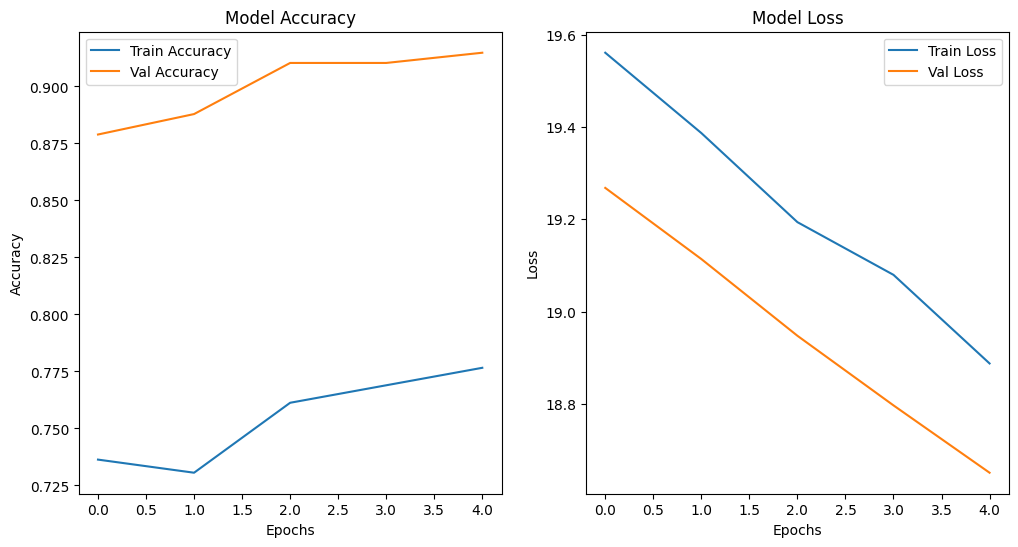

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step
                       precision    recall  f1-score   support

Potato___Early_blight       0.66      0.82      0.73        50
 Potato___Late_blight       0.83      0.76      0.79       150
     Potato___healthy       0.26      0.26      0.26        23

             accuracy                           0.72       223
            macro avg       0.58      0.61      0.59       223
         weighted avg       0.73      0.72      0.72       223



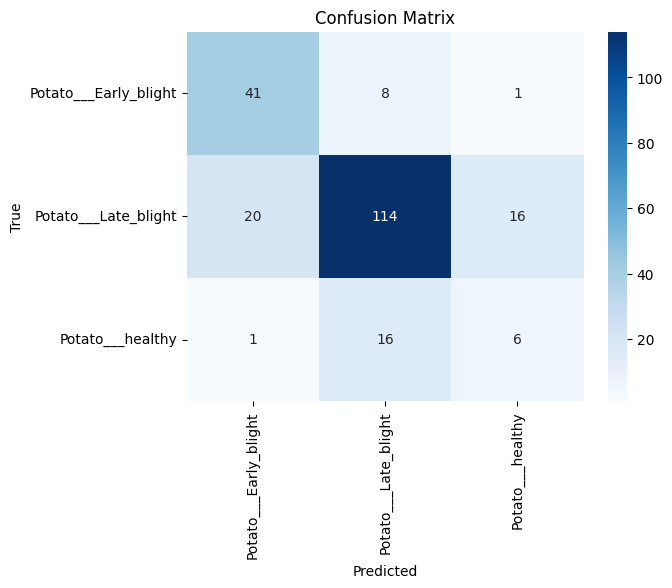

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on validation data
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=list(train_generator.class_indices.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



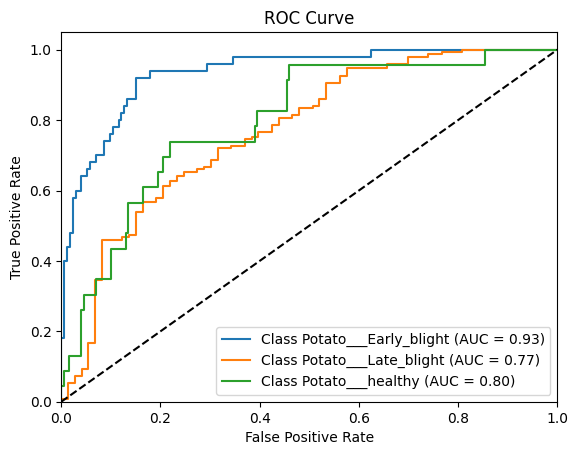

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels for ROC (One-vs-Rest approach)
y_true_binarized = label_binarize(y_true, classes=range(len(train_generator.class_indices)))
n_classes = y_true_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {list(train_generator.class_indices.keys())[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Save the fine-tuned model in the newer .keras format
model.save('fine_tuned2_model.keras')